In [1]:
import pandas as pd
import numpy as np
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_squared_error
import plotly.express as px

import warnings

warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.append("../utils/")

In [3]:
import pipeline_helpers as ph

### Pipeline to evaluate the Optimized Hyperparameters on the test set
- Update pool price 12 steps at a time.

In [4]:
X_train = pd.read_csv(
    "https://raw.githubusercontent.com/slalom-ubc-mds/Power-Price-Prediction/main/data/processed/train/X_train.csv",
    parse_dates=["date"],
    index_col="date",
)

y_train = pd.read_csv(
    "https://raw.githubusercontent.com/slalom-ubc-mds/Power-Price-Prediction/main/data/processed/train/y_train.csv",
    parse_dates=["date"],
    index_col="date",
)

X_train = X_train.sort_values(by="date")
X_train = X_train.asfreq("H")
y_train = y_train.sort_values(by="date")
y_train = y_train.asfreq("H")

In [5]:
X_test = pd.read_csv(
    "https://raw.githubusercontent.com/slalom-ubc-mds/Power-Price-Prediction/main/data/processed/test/X_test.csv",
    parse_dates=["date"],
    index_col="date",
)

y_test = pd.read_csv(
    "https://raw.githubusercontent.com/slalom-ubc-mds/Power-Price-Prediction/main/data/processed/test/y_test.csv",
    parse_dates=["date"],
    index_col="date",
)

X_test = X_test.sort_values(by="date")
X_test = X_test.asfreq("H")
y_test = y_test.sort_values(by="date")
y_test = y_test.asfreq("H")

In [6]:
# Adjust the test set based on how many hours we want to predict
# X_test = X_test[:"2023-02-03"]
# y_test = y_test[:"2023-02-03"]

In [7]:
# Adjust the params to test run the pipeline. If not specified, the default optimized parameters will be used.
lgbm_pipeline = ph.initialize_optimized_lgbm_forecaster()
fh = ForecastingHorizon(np.arange(1, 12 + 1))

In [8]:
forecast_len = 12
step_length = 12

In [9]:
lgbm_pipeline.fit(y=y_train, X=X_train, fh=fh)

ForecastingPipeline(steps=[('forecaster',
                            TransformedTargetForecaster(steps=[('forecast',
                                                                DirectTabularRegressionForecaster(estimator=LGBMRegressor(boosting_type='dart', device='gpu', learning_rate=0.01,
              max_depth=15, n_estimators=1000, num_leaves=70, reg_alpha=30,
              reg_lambda=20),
                                                                                                  window_length=24))]))])

In [10]:
rolling_prediction_df = ph.get_rolling_predictions(lgbm_pipeline, X_train, X_test, y_test, fh, step_length, forecast_len, verbose=False)

In [11]:
fold_actuals, fold_predictions_list, rmse_list = ph.get_fold_predictions(rolling_prediction_df, y_test)

Average RMSE for each fold: 133.9725411664745
STD RMSE for each fold: 114.48005966323032


In [12]:
# Print Average RMSE of all folds
print(f"Average RMSE for each fold: {np.mean(rmse_list)}")

Average RMSE for each fold: 133.9725411664745


In [13]:
# Print Std RMSE of all folds
print(f"RMSE Standard Deviation: {np.std(rmse_list)}")

RMSE Standard Deviation: 114.48005966323032


In [14]:
y_hist = pd.read_csv(
    "https://raw.githubusercontent.com/slalom-ubc-mds/Power-Price-Prediction/main/data/processed/filtered_target_medium.csv",
    parse_dates=["date"],
    index_col="date",
)

y_hist = y_hist.sort_values(by="date")
y_hist = y_hist.asfreq("H")

In [15]:
ddf = ph.get_plotting_df(fold_actuals=fold_actuals, fold_predictions_list=fold_predictions_list, y_hist=y_hist)

In [16]:
fig = px.line(ddf, x="periodstep", y=["HistoricalPrice", "FuturePrice", "Predicted"], animation_frame="timestep")
fig.update_layout(height=700)  
fig.show()

In [17]:
ph.get_aeso_predictions(y_test.index[0], y_test.index[-1])

One step prediction errors for AESO forecasts: 118.55 CAD/MWh.
As these are one step predictions, the error should be lesser than ours since ours is 12 step prediction errors.


In [60]:
residuals = [[] for _ in range(12)]

for actual, prediction in zip(fold_actuals, fold_predictions_list):
    actual_values = actual.values.flatten()
    prediction_values = prediction.values.flatten()

    for i in range(12):
        residual = actual_values[i] - prediction_values[i]
        residuals[i].append(residual)

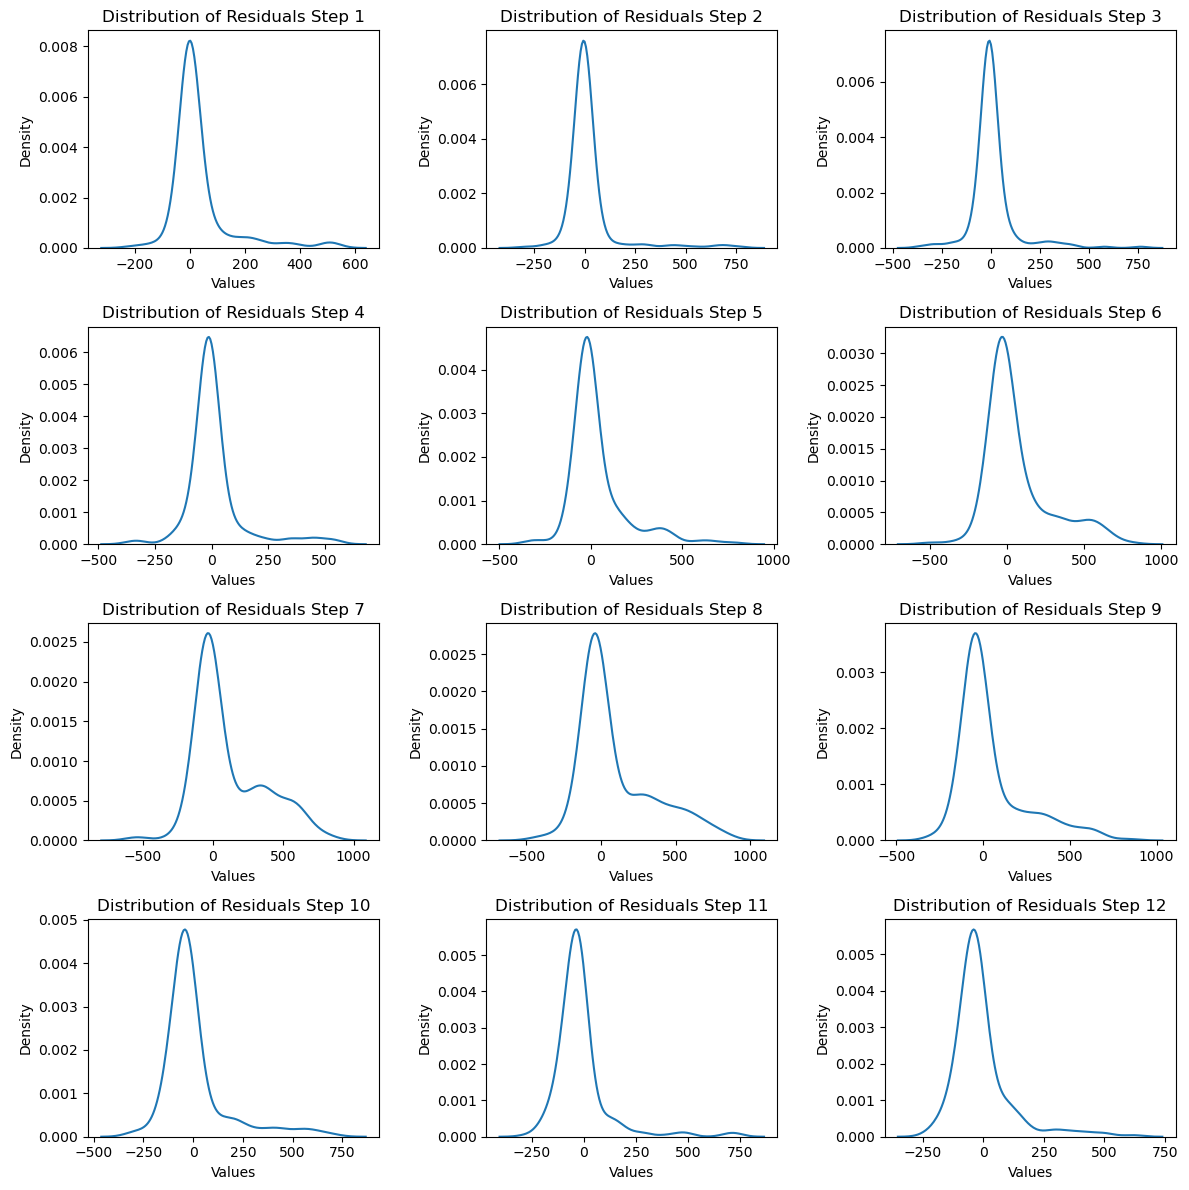

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create subplots with 4 rows and 3 columns
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

# Flatten the axes array
axes = axes.flatten()

# Loop through the residuals and create subplots
for i, residual in enumerate(residuals):
    sns.kdeplot(residual, ax=axes[i])
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Distribution of Residuals Step {i+1}')

# Adjust the layout and spacing
fig.tight_layout()

# Display the plots
plt.show()


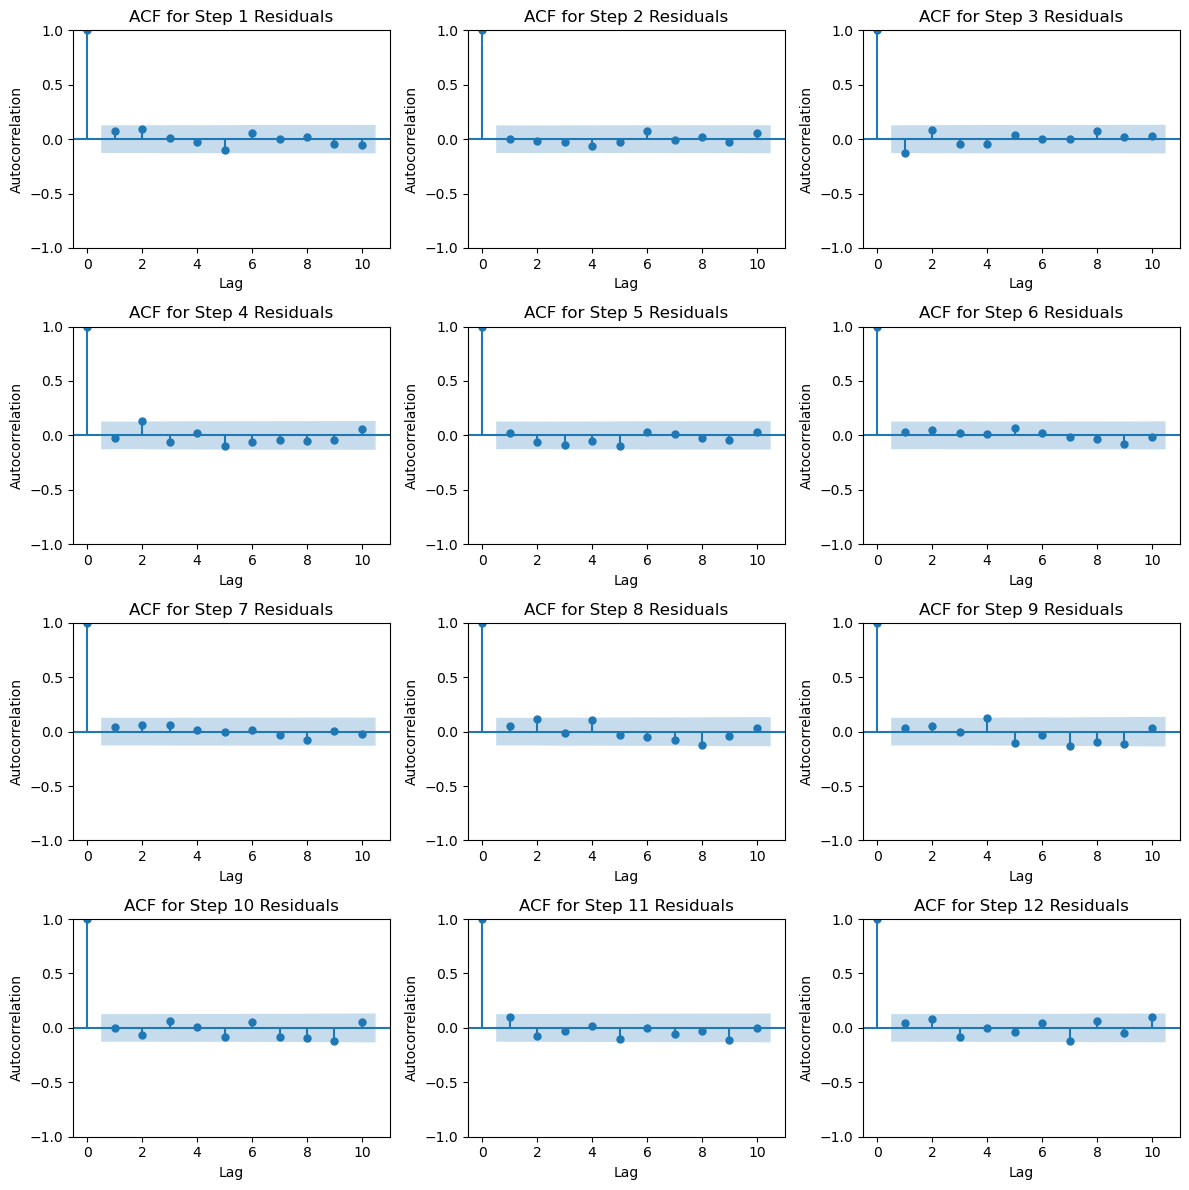

In [62]:
# Create subplots with 4 rows and 3 columns
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

# Flatten the axes array
axes = axes.flatten()

# Loop through the residuals and create subplots
for i, residual in enumerate(residuals):
    plot_acf(residual, ax=axes[i], lags=10)
    axes[i].set_xlabel('Lag')
    axes[i].set_ylabel('Autocorrelation')
    axes[i].set_title(f'ACF for Step {i+1} Residuals')

# Adjust the layout and spacing
fig.tight_layout()

# Display the plots
plt.show()

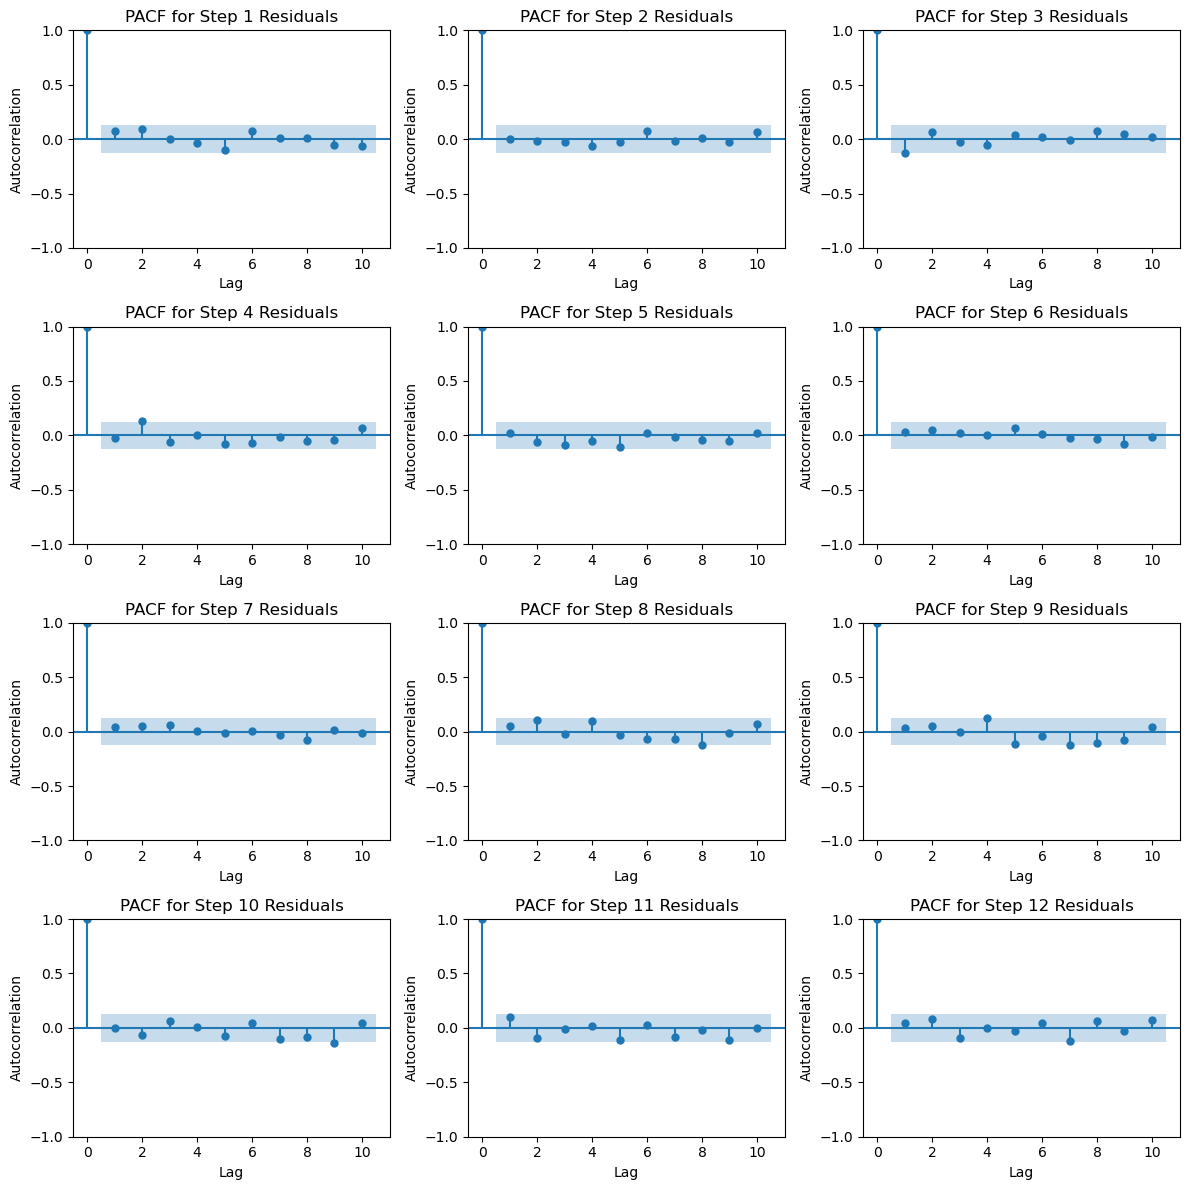

In [63]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

# Flatten the axes array
axes = axes.flatten()

# Loop through the residuals and create subplots
for i, residual in enumerate(residuals):
    plot_pacf(residual, ax=axes[i], lags=10)
    axes[i].set_xlabel('Lag')
    axes[i].set_ylabel('Autocorrelation')
    axes[i].set_title(f'PACF for Step {i+1} Residuals')

# Adjust the layout and spacing
fig.tight_layout()

# Display the plots
plt.show()

### Residual Analysis

Based on the above analysis, we can conclude that the residuals are not auto correlated. Both the ACF and PACF plots cuts off after the first lag. This means that the residuals are not correlated with each other. This is a good sign.

Although the residuals are not auto correlated, the residuals are not normally distributed. The residuals are positive skewed. This means that the model generally under predicts the price. This is not a good sign.